## Отсутствует скрипт `SemanticSimilarity`

---
## Описание
Данный ноутбук содержит подсчет семантического сходства Резника и Лина. Мера Резника, определяет сходство между классами x и y как информационное содержание их наиболее информативного общего предка (MICA):

Мера Резника:
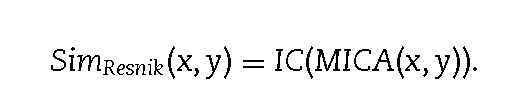

---

Мера Лина

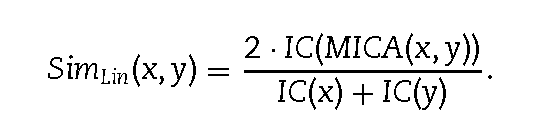

---


In [ ]:
org_id = '4932'

### Call Semantic Similarity Computation script for Resnik similarity measure

In [2]:

!groovy SemanticSimilarity -i data/train/{org_id}.annotation.txt -s 0 -o data/train/{org_id}.sim_resnik.txt



OBO loader set default-namespace http://go/
-------------------------------------
Loading OBO specification from:data/go.obo
-------------------------------------
Term specified : 47434
skipping 2855 obsolete Terms
OBO Loading ok.
OBO specification loaded.
-------------------------------------
-------------------------------------
Rerooting
-------------------------------------
Fetching root node, uri: http://go/virtualRoot
Rooting taxonomic Graph using http://go/virtualRoot
Number of roots 3
Starting process from 27439 vertices
isDag : true
Number of roots detected: 3
Rooting performed using http://go/virtualRoot as root 3 edges created
Number of roots 1
isDag : true
Rerooting performed
-------------------------------------
Loading Semantic Measures Engine for graph http://go/
Graph Info: 
http://go/
Vertices
	Total   : 50158  {e.g. http://4932.YBR274W}
Edges 	  : 134754


---------------------------------------------------------------
Pre-processing
----------------------------------

### Call Semantic Similarity Computation script for Lin similarity measure

In [3]:

!groovy SemanticSimilarity -i data/train/{org_id}.annotation.txt -s 1 -o data/train/{org_id}.sim_lin.txt


OBO loader set default-namespace http://go/
-------------------------------------
Loading OBO specification from:data/go.obo
-------------------------------------
Term specified : 47434
skipping 2855 obsolete Terms
OBO Loading ok.
OBO specification loaded.
-------------------------------------
-------------------------------------
Rerooting
-------------------------------------
Fetching root node, uri: http://go/virtualRoot
Rooting taxonomic Graph using http://go/virtualRoot
Number of roots 3
Starting process from 27439 vertices
isDag : true
Number of roots detected: 3
Rooting performed using http://go/virtualRoot as root 3 edges created
Number of roots 1
isDag : true
Rerooting performed
-------------------------------------
Loading Semantic Measures Engine for graph http://go/
Graph Info: 
http://go/
Vertices
	Total   : 50158  {e.g. http://4932.YBR274W}
Edges 	  : 134754


---------------------------------------------------------------
Pre-processing
----------------------------------

### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [ ]:
from scipy.stats import rankdata
import numpy as np
import click as ck

org_id = '9606'
sim_file = f'data/train/{org_id}.sim_lin.txt'
train_data_file = f'data/train/{org_id}.protein.links.v11.0.txt'
valid_data_file = f'data/valid/{org_id}.protein.links.v11.0.txt'
test_data_file = f'data/test/{org_id}.protein.links.v11.0.txt'

def load_data(data_file, proteins):
    data = []
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = it[0]
            id2 = it[1]
            if id1 not in proteins or id2 not in proteins:
                continue
            data.append((proteins[id1], proteins[id2]))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc


with open(sim_file, 'r') as f:
    proteins = next(f).strip().split('\t')
    prots_dict = {v: k for k, v in enumerate(proteins)}
    sim = np.zeros((len(proteins), len(proteins)), dtype=np.float32)
    i = 0
    for line in f:
        line = line.replace('null', '0.0')
        s = line.strip().split('\t')
        s = np.array(list(map(float, s)), dtype=np.float32)
        sim[i, :] = s
        i += 1
train_data = load_data(train_data_file, prots_dict)
valid_data = load_data(valid_data_file, prots_dict)
trlabels = np.ones((len(proteins), len(proteins)), dtype=np.int32)
for c, d in train_data:
    trlabels[c, d] = 0
for c, d in valid_data:
    trlabels[c, d] = 0

test_data = load_data(test_data_file, prots_dict)
top10 = 0
top100 = 0
mean_rank = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
n = len(test_data)
labels = np.zeros((len(proteins), len(proteins)), dtype=np.int32) 
ranks = {}
franks = {}
with ck.progressbar(test_data) as prog_data:
    for c, d in prog_data:
        labels[c, d] = 1
        index = rankdata(-sim[c, :], method='average')
        rank = index[d]
        if rank <= 10:
            top10 += 1
        if rank <= 100:
            top100 += 1
        mean_rank += rank
        if rank not in ranks:
            ranks[rank] = 0
        ranks[rank] += 1

        # Filtered rank
        fil = sim[c, :] * (labels[c, :] | trlabels[c, :])
        index = rankdata(-fil, method='average')
        rank = index[d]
        if rank <= 10:
            ftop10 += 1
        if rank <= 100:
            ftop100 += 1
        fmean_rank += rank
        if rank not in franks:
            franks[rank] = 0
        franks[rank] += 1

    print()
    top10 /= n
    top100 /= n
    mean_rank /= n
    ftop10 /= n
    ftop100 /= n
    fmean_rank /= n

    rank_auc = compute_rank_roc(ranks, len(proteins))
    frank_auc = compute_rank_roc(franks, len(proteins))
    print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
    print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')
